# Assignment 1 notMNIST

In [7]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
%matplotlib inline

In [8]:
url = 'http://commodatastorage.googleapis.com/books1000/'
last_percent_reported = None

def download_progress(count, blockSize, totalSize):
    global last_percent_reported
    percent = int(count * blockSize * 100 / totalSize)
    
    if last_percent_reported != percent:
        if percent % 5 == 0:
            sys.stdout.write("%s%%" % percent)
            sys.stdout.flush()
        else:
            sys.stdout.write(".")
            sys.stdout.flush()
    last_percent_reported = percent
def maybe_download(filename, expected_bytes, force=False):
    if force or os.path.exists(filename):
        print('Attempting to download: ', filename)
        filename, _ = urlretrieve(url + filename, filename, reporthook=download_progress)
        print('\nDownload Complete!')
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified', filename)
    else:
        print('download file size : %s' , statinfo.st_size)
        raise Exception(
          'Failed to verify ' + filename + '. Can you get to it with a browser?')
    return filename
#train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
#test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)
train_filename = 'notMNIST_large.tar.gz'
test_filename = 'notMNIST_small.tar.gz'

In [9]:
num_classes = 10
np.random.seed(11)

def maybe_extract(filename, force=False):
    root = os.path.splitext(os.path.splitext(filename)[0])[0]
    if os.path.isdir(root) and not force:
        print('%s already present - Skpping extraction of %s.' % (root, filename))
    else:
        print('Extracting data for %s. This may take a while. Please wait.' % root)
        tar = tarfile.open(filename)
        sys.stdout.flush()
        tar.extractall()
        tar.close()
    data_folders = [
        os.path.join(root, d) for d in sorted(os.listdir(root))
        if os.path.isdir(os.path.join(root, d))
    ]
    if len(data_folders) != num_classes:
        raise Exception('Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
    print(data_folders)
    return data_folders
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

notMNIST_large already present - Skpping extraction of notMNIST_large.tar.gz.
['notMNIST_large/A', 'notMNIST_large/B', 'notMNIST_large/C', 'notMNIST_large/D', 'notMNIST_large/E', 'notMNIST_large/F', 'notMNIST_large/G', 'notMNIST_large/H', 'notMNIST_large/I', 'notMNIST_large/J']
notMNIST_small already present - Skpping extraction of notMNIST_small.tar.gz.
['notMNIST_small/A', 'notMNIST_small/B', 'notMNIST_small/C', 'notMNIST_small/D', 'notMNIST_small/E', 'notMNIST_small/F', 'notMNIST_small/G', 'notMNIST_small/H', 'notMNIST_small/I', 'notMNIST_small/J']


## Problem 1
### Let's take a peek at some of the data to make sure it looks sensible

In [10]:
import random
def display_image(data_folders, sample_size):
    for folder in data_folders:
        print(folder)
        image_files = os.listdir(folder)
        image_sample = random.sample(image_files, sample_size)
        for image in image_sample:
            print(image)
            image_file = os.path.join(folder, image)
            print(image_file)
            i = Image(filename=image_file)
            display(i)

display_image(test_folders, 1)

notMNIST_small/A
Q2hlbHRlbmhhbUJULUl0YWxpYy5vdGY=.png
notMNIST_small/A/Q2hlbHRlbmhhbUJULUl0YWxpYy5vdGY=.png


notMNIST_small/B
QnJvYWR3YXlQLnR0Zg==.png
notMNIST_small/B/QnJvYWR3YXlQLnR0Zg==.png


notMNIST_small/C
RHJvcGxldC5vdGY=.png
notMNIST_small/C/RHJvcGxldC5vdGY=.png


notMNIST_small/D
RmFpcmZpZWxkTEgtSGVhdnlTQy5vdGY=.png
notMNIST_small/D/RmFpcmZpZWxkTEgtSGVhdnlTQy5vdGY=.png


notMNIST_small/E
Q29yaW50aGlhbi50dGY=.png
notMNIST_small/E/Q29yaW50aGlhbi50dGY=.png


notMNIST_small/F
QmFza2VydmlsbGVCUS1JdGFsaWMub3Rm.png
notMNIST_small/F/QmFza2VydmlsbGVCUS1JdGFsaWMub3Rm.png


notMNIST_small/G
R2Fkem9veEJvbGQub3Rm.png
notMNIST_small/G/R2Fkem9veEJvbGQub3Rm.png


notMNIST_small/H
Q2Fzc2FuZHJhRUYtQm9sZC5vdGY=.png
notMNIST_small/H/Q2Fzc2FuZHJhRUYtQm9sZC5vdGY=.png


notMNIST_small/I
SG9iYml0IFNGLnR0Zg==.png
notMNIST_small/I/SG9iYml0IFNGLnR0Zg==.png


notMNIST_small/J
RWx3b29kLnR0Zg==.png
notMNIST_small/J/RWx3b29kLnR0Zg==.png


In [13]:
image_size = 28
pixel_depth = 255.0

def load_letter(folder, min_num_images):
    image_files = os.listdir(folder)
    dataset = np.ndarray(shape=(len(image_files), image_size, image_size), dtype=np.float32)
    print(folder)
    num_images = 0
    for image in image_files:
        image_file = os.path.join(folder, image)
        try:
            image_data = (ndimage.imread(image_file).astype(float) - 
                         pixel_depth / 2) / pixel_depth
            if image_data.shape != (image_size, image_size):
                raise Exeption('Unexpected image shape: %s' % str(image_data.shape))
            dataset[num_images, :, :] = image_data
            num_images = num_images + 1
            
        except IOError as e:
            print('Could not read : ', image_file, ':', e, '- it\'s ok, skipping')
    print (dataset.shape)
    dataset = dataset[0:num_images, :, :]
    print(dataset.shape)
    
    if num_images < min_num_images:
        raise Exception('May fewer images than expected : %d < %d' % (num_images, min_num_images))
    
    print('Full dataset tensor: ', dataset.shape)
    print ('Mean: ', np.mean(dataset))
    print('Standard deviation:' , np.std(dataset))

def maybe_pickle(data_folders, min_num_images_per_class, force=False):
    dataset_name = []
    for folder in data_folders:
        set_filename = folder + '.pickle'
        dataset_name.append(set_filename)
        if os.path.exists(set_filename) and not force:
            print('%s already present - Skipping pickling.' % set_filename)
        else:
            print('Pickling %s.' % set_filename)
            dataset = load_letter(folder, min_num_images_per_class)
            try:
                with open(set_filename, 'wb') as f:
                    pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
            except Exception as e:
                print('Unable to save data to' , set_filename, ':' , e)
    return dataset_name
train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

notMNIST_large/A.pickle already present - Skipping pickling.
notMNIST_large/B.pickle already present - Skipping pickling.
notMNIST_large/C.pickle already present - Skipping pickling.
notMNIST_large/D.pickle already present - Skipping pickling.
notMNIST_large/E.pickle already present - Skipping pickling.
notMNIST_large/F.pickle already present - Skipping pickling.
notMNIST_large/G.pickle already present - Skipping pickling.
notMNIST_large/H.pickle already present - Skipping pickling.
notMNIST_large/I.pickle already present - Skipping pickling.
notMNIST_large/J.pickle already present - Skipping pickling.
notMNIST_small/A.pickle already present - Skipping pickling.
notMNIST_small/B.pickle already present - Skipping pickling.
notMNIST_small/C.pickle already present - Skipping pickling.
notMNIST_small/D.pickle already present - Skipping pickling.
notMNIST_small/E.pickle already present - Skipping pickling.
notMNIST_small/F.pickle already present - Skipping pickling.
notMNIST_small/G.pickle 

# Assignment 2 Fullyconnected 

In [1]:
from __future__ import print_function
import numpy as np
import tensorflow as tf                  
from six.moves import cPickle as pickle   
from six.moves import range              

In [2]:
pickle_file = 'notMNIST.pickle'    # pickle file name

with open(pickle_file, 'rb') as f:    # pickle file 이진 읽기 모드로 열기(r : read, b : binary) 
    save = pickle.load(f)    # load pickle file
    train_dataset = save['train_dataset']    # train_dataset 으로 저장한 data 가져 오기
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save    # memory 해제
    
    
    print('Training set', train_dataset.shape, train_labels.shape)    # dataset 의 형태 확인
    print('Validation set', valid_dataset.shape, valid_labels.shape)
    print('Test set', test_dataset.shape, test_labels.shape)
    print(test_labels)
    print(test_dataset)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)
[3 6 4 ..., 6 9 0]
[[[-0.5        -0.5        -0.5        ..., -0.5        -0.5        -0.5       ]
  [-0.5        -0.5        -0.5        ..., -0.5        -0.5        -0.5       ]
  [-0.5        -0.5        -0.5        ..., -0.5        -0.5        -0.5       ]
  ..., 
  [ 0.42156863  0.5         0.42156863 ..., -0.4254902  -0.5        -0.49607843]
  [ 0.05686275  0.5         0.18627451 ..., -0.5        -0.49215686 -0.5       ]
  [-0.42156863 -0.20588236 -0.31568629 ..., -0.49215686 -0.5        -0.5       ]]

 [[-0.5        -0.5        -0.5        ..., -0.5        -0.5        -0.5       ]
  [-0.5        -0.5        -0.5        ..., -0.5        -0.5        -0.5       ]
  [-0.5        -0.5        -0.5        ..., -0.49607843 -0.5        -0.5       ]
  ..., 
  [-0.5        -0.5        -0.5        ..., -0.17450981  0.5         0.47254902]
  [-0.5        -0.5        -0.5        

In [3]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
    dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)    # 3차원 행렬을 float32 타입의 2차원 행렬로 변경
    print(np.arange(num_labels))
    print(labels[:,None])

    labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)    # array slice 를 통해 lavels 를 2
    return dataset, labels

train_dataset, train_labels = reformat(train_dataset, train_labels)    # dataset 차수 변경하기
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)

print('Training set' , train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

[0 1 2 3 4 5 6 7 8 9]
[[4]
 [9]
 [6]
 ..., 
 [2]
 [4]
 [4]]
[0 1 2 3 4 5 6 7 8 9]
[[1]
 [9]
 [3]
 ..., 
 [8]
 [9]
 [8]]
[0 1 2 3 4 5 6 7 8 9]
[[3]
 [6]
 [4]
 ..., 
 [6]
 [9]
 [0]]
Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [4]:
print(test_labels)

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  1.]
 [ 1.  0.  0. ...,  0.  0.  0.]]


In [5]:
arr = np.array([[[1, 2, 3], [4, 5, 6]],[[6, 7, 8], [9, 0, 1]],[[16, 17, 18], [19, 10, 11]]])
print(arr)
print(arr.shape)
arr = arr.reshape((-1, 2*3)).astype(np.float32)
print(arr)
print(arr.shape)

[[[ 1  2  3]
  [ 4  5  6]]

 [[ 6  7  8]
  [ 9  0  1]]

 [[16 17 18]
  [19 10 11]]]
(3, 2, 3)
[[  1.   2.   3.   4.   5.   6.]
 [  6.   7.   8.   9.   0.   1.]
 [ 16.  17.  18.  19.  10.  11.]]
(3, 6)


## multinormial classification ( softmax regression)

In [6]:
train_subset = 10000

graph = tf.Graph()
with graph.as_default():
    tf_train_dataset = tf.constant(train_dataset[:train_subset, :])    # train_dataset 을 slice 하여 행을 0~9999(10000개)사용 열은 유지(10)
    tf_train_labels = tf.constant(train_labels[:train_subset])
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    print(tf_train_dataset.get_shape)
    
    weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels]))    # 784 X 10 weight를 랜덤(정규화?)하게 초기화
    biases = tf.Variable(tf.zeros([num_labels]))    # 10 X 1 biases 를 0 로 초기화  
    
    logits = tf.matmul(tf_train_dataset, weights) + biases    # hyperthsis = wx + b
    loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))    # tensor 에서 제공하는 softmax , closs entropy 한방에
                                                                         # cast func = -log(y^)
    
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)    # loss 를 gradientdesent 로 optimizer 하여 최소 값 구함. learnning rate 는 0.5 사용
    
    train_prediction = tf.nn.softmax(logits)    # train data set 의 예측 값
    valid_prediction = tf.nn.softmax(
    tf.matmul(tf_valid_dataset, weights) + biases)    # train 과 동일하게 validation 예측
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

<bound method Tensor.get_shape of <tf.Tensor 'Const:0' shape=(10000, 784) dtype=float32>>


In [7]:
num_steps = 801

def accuracy(predictions, labels):    # accuracy 를 % 로 표현
    #print(np.argmax(predictions, 1))
    #print(np.argmax(labels, 1))
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
           / predictions.shape[0])    # 10000 개의 train data set 중 predict 값이 맞은 개수의 합을 10000으로 나누고 100으로 곱합

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print('Initialized')
    for step in range(num_steps):    # 801번 train
        _, l, predictions = session.run([optimizer, loss, train_prediction])
        if(step % 100 == 0):
            print('Loss at step %d: %f' % (step, l))    # step 과 loss 출력
            print('Training accuracy: %.1f%%' % accuracy(
                valid_prediction.eval(), valid_labels))
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))    # eval()? test dataset 정확도 출력

Initialized
Loss at step 0: 20.898104
Training accuracy: 7.6%
Loss at step 100: 2.327554
Training accuracy: 70.6%
Loss at step 200: 1.866469
Training accuracy: 73.4%
Loss at step 300: 1.631458
Training accuracy: 74.2%
Loss at step 400: 1.474042
Training accuracy: 74.7%
Loss at step 500: 1.355821
Training accuracy: 75.0%
Loss at step 600: 1.261784
Training accuracy: 75.2%
Loss at step 700: 1.184033
Training accuracy: 75.4%
Loss at step 800: 1.118059
Training accuracy: 75.5%
Test accuracy: 82.6%


In [8]:
batch_size = 128

graph = tf.Graph()
with graph.as_default():
    tf_train_dataset = tf.placeholder(tf.float32,
                                     shape = (batch_size, image_size * image_size))    # 128 x 784
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)    # valiable initialize
    
    weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))
    
    logits = tf.matmul(tf_train_dataset, weights) + biases
    loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(
    tf.matmul(tf_valid_dataset, weights) + biases)
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

In [9]:
num_steps = 3001

with tf.Session(graph = graph) as session:
    tf.initialize_all_variables().run()
    print('Initialized')
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)    # 0, 128, 256, ... , 
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
        [optimizer, loss, train_prediction], feed_dict=feed_dict)    # feed_dict=> placeholder 에 값 설정
        if(step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(
                valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 15.219501
Minibatch accuracy: 14.8%
Validation accuracy: 14.7%
Minibatch loss at step 500: 1.435687
Minibatch accuracy: 76.6%
Validation accuracy: 75.4%
Minibatch loss at step 1000: 1.503235
Minibatch accuracy: 75.0%
Validation accuracy: 76.6%
Minibatch loss at step 1500: 0.887524
Minibatch accuracy: 83.6%
Validation accuracy: 77.5%
Minibatch loss at step 2000: 1.067979
Minibatch accuracy: 77.3%
Validation accuracy: 78.7%
Minibatch loss at step 2500: 0.724542
Minibatch accuracy: 79.7%
Validation accuracy: 78.2%
Minibatch loss at step 3000: 1.100917
Minibatch accuracy: 73.4%
Validation accuracy: 78.8%
Test accuracy: 85.9%


## Problem. 1-hidden layer(activate function =  ReLu)

In [32]:
num_node = 1024


graph = tf.Graph()
with graph.as_default():
    tf_train_dataset = tf.placeholder(tf.float32,
                                     shape = (batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    w1 = tf.Variable(tf.truncated_normal([image_size * image_size, num_node]))
    b1 = tf.Variable(tf.zeros([num_node]))
    w2 = tf.Variable(tf.truncated_normal([num_node, num_labels]))
    b2 = tf.Variable(tf.zeros([num_labels]))

    h1 = tf.nn.relu(tf.matmul(tf_train_dataset, w1) + b1)    # hidden layer
    logits = tf.matmul(h1, w2) + b2

    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))

    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(tf.matmul(tf.nn.relu(tf.matmul(tf_valid_dataset, w1) + b1), w2) + b2)
    test_prediction = tf.nn.softmax(tf.matmul(tf.nn.relu(tf.matmul(tf_test_dataset, w1) + b1), w2) + b2)

In [33]:
num_steps = 3001

with tf.Session(graph = graph) as session:
    tf.initialize_all_variables().run()
    print('Initialized')
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
        [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if(step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(
                valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 305.156738
Minibatch accuracy: 8.6%
Validation accuracy: 36.1%
Minibatch loss at step 500: 19.512383
Minibatch accuracy: 82.0%
Validation accuracy: 81.1%
Minibatch loss at step 1000: 22.571728
Minibatch accuracy: 75.0%
Validation accuracy: 78.5%
Minibatch loss at step 1500: 6.235578
Minibatch accuracy: 84.4%
Validation accuracy: 81.7%
Minibatch loss at step 2000: 6.087286
Minibatch accuracy: 84.4%
Validation accuracy: 80.0%
Minibatch loss at step 2500: 3.662671
Minibatch accuracy: 85.2%
Validation accuracy: 81.6%
Minibatch loss at step 3000: 3.890370
Minibatch accuracy: 80.5%
Validation accuracy: 81.0%
Test accuracy: 88.3%


## optimization

In [21]:
num_node = 1024


graph = tf.Graph()
with graph.as_default():
    tf_train_dataset = tf.placeholder(tf.float32,
                                     shape = (batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    w1 = tf.Variable(tf.truncated_normal([image_size * image_size, num_node]))
    b1 = tf.Variable(tf.zeros([num_node]))
    w2 = tf.Variable(tf.truncated_normal([num_node, num_labels]))
    b2 = tf.Variable(tf.zeros([num_labels]))

    h1 = tf.nn.relu(tf.matmul(tf_train_dataset, w1) + b1) 
    logits = tf.matmul(h1, w2) + b2

    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))

    #optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    optimizer = tf.train.AdamOptimizer(0.01).minimize(loss)

    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(tf.matmul(tf.nn.relu(tf.matmul(tf_valid_dataset, w1) + b1), w2) + b2)
    test_prediction = tf.nn.softmax(tf.matmul(tf.nn.relu(tf.matmul(tf_test_dataset, w1) + b1), w2) + b2)

In [22]:
num_steps = 3001

with tf.Session(graph = graph) as session:
    tf.initialize_all_variables().run()
    print('Initialized')
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
        [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if(step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(
                valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 362.009460
Minibatch accuracy: 5.5%
Validation accuracy: 24.6%
Minibatch loss at step 500: 37.268814
Minibatch accuracy: 78.9%
Validation accuracy: 81.2%
Minibatch loss at step 1000: 29.013060
Minibatch accuracy: 82.0%
Validation accuracy: 82.4%
Minibatch loss at step 1500: 16.397827
Minibatch accuracy: 82.8%
Validation accuracy: 81.7%
Minibatch loss at step 2000: 8.507425
Minibatch accuracy: 84.4%
Validation accuracy: 83.0%
Minibatch loss at step 2500: 2.542193
Minibatch accuracy: 88.3%
Validation accuracy: 82.0%
Minibatch loss at step 3000: 3.850550
Minibatch accuracy: 81.2%
Validation accuracy: 83.3%
Test accuracy: 89.8%


# Assignment 3 Deep Learning

In [13]:
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
import matplotlib.pyplot as plt
%matplotlib inline    

In [14]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    
    del save
    
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set' , valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


In [15]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
    dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
    labels = (np.arange(num_labels) == labels[:, None]).astype(np.float32)
    return dataset, labels

train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)

print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [16]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
           / predictions.shape[0])

In [31]:
batch_size = 128

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  beta_regul = tf.placeholder(tf.float32)
  
  # Variables.
  weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  logits = tf.matmul(tf_train_dataset, weights) + biases
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)) + beta_regul * tf.nn.l2_loss(weights)
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

In [32]:
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : 1e-3}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 21.547451
Minibatch accuracy: 10.2%
Validation accuracy: 15.3%
Minibatch loss at step 500: 2.663783
Minibatch accuracy: 77.3%
Validation accuracy: 76.0%
Minibatch loss at step 1000: 2.080396
Minibatch accuracy: 74.2%
Validation accuracy: 77.5%
Minibatch loss at step 1500: 1.023589
Minibatch accuracy: 84.4%
Validation accuracy: 80.1%
Minibatch loss at step 2000: 0.936654
Minibatch accuracy: 83.6%
Validation accuracy: 81.3%
Minibatch loss at step 2500: 0.649134
Minibatch accuracy: 88.3%
Validation accuracy: 81.5%
Minibatch loss at step 3000: 0.854148
Minibatch accuracy: 78.1%
Validation accuracy: 81.9%
Test accuracy: 88.7%


In [33]:
num_steps = 3001
regul_val = [pow(10, i) for i in np.arange(-4, -2, 0.1)]
accuracy_val = []

for regul in regul_val:
  with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
      offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
      batch_data = train_dataset[offset:(offset + batch_size), :]
      batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
      feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : regul}
      _, l, predictions = session.run(
        [optimizer, loss, train_prediction], feed_dict=feed_dict)
    accuracy_val.append(accuracy(test_prediction.eval(), test_labels))

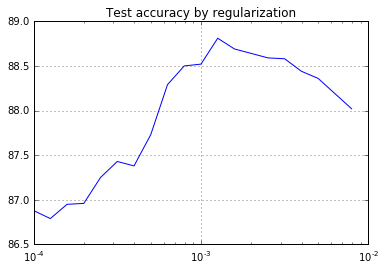

In [34]:
plt.semilogx(regul_val, accuracy_val)
plt.grid(True)
plt.title('Test accuracy by regularization')
plt.show()

# assignment 4 convolutions

In [10]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

graph = tf.Graph()

with graph.as_default():
    tf_train_dataset = tf.placehodler(
    tf.float32, shape=(batch_size, image_size, image_size, num))

SyntaxError: invalid syntax (<ipython-input-10-6f4376fd9e3c>, line 8)